# Выбор архитектуры модели для сегментации типов ландшафта по данным аэрофотосъемки

## Содержание

* [Задача](#Задача)
* [Исследуемые параметры](#Исследуемые-параметры)
* [Измеряемые характеристики](#Измеряемые-характеристики)
* [Описание исследования](#Описание-исследования)
* [Результат исследования](#Результат-исследования)
* [Вывод](#Вывод)

## Задача

Изучить влияние параметров UNet на качество модели и выбрать оптимальные значения.

## Исследуемые параметры

Количество фильров в блоках.

## Измеряемые характеристики

Метрика IoU на тестовой части датасета.

## Описание исследования

Импорты библиотек и вспомогательных скриптов

In [1]:
import sys
sys.path.append('../')

import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import batchflow as bf

from batchflow import F,V,B,C
from batchflow import FilesIndex, Dataset
from batchflow.models.tf import UNet
from batchflow.research import Research, Results, Option

from aerial_batch import AerialBatch, get_origs

%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


Вспомогательная функция для работы с масками:

In [2]:
# Another representation 
# 0 Unknown
# 1 Water
# 2 Forest land
# 3 Urban land
# 5 Rangeland
# 6 Agriculture land
# 7 Barren land

# def make_mask(masks):
#     """
#     """
#     new_mask = np.zeros(mask.shape + (2,))
#     new_mask[:,:,1]

Задание датасета

In [3]:
ind = FilesIndex(path='../ignore/deepglobe/train/*.jpg')
ads = Dataset(ind, AerialBatch)
ads.split(0.8, shuffle=True)

Задание модели

In [4]:
model_config = {
    'initial_block/inputs': 'images',
    'inputs': dict(images={'shape': (250,250,3)}, 
                   masks={'name':'targets',
                          'shape': (250,250,1)}),
    'filters': C('filters'),
    'head/num_classes': 7,
    'loss':'ce',
    'optimizer': 'Adam',
    'output': ['proba']
}

Описание пайплайнов для обучения и оценки моделей

In [6]:
n_reps = 1
batch_size = 2
n_epochs = 1
n_iters = int(n_epochs * (len(ads.train) / batch_size))
iters_to_test = 32
itt = "%{}".format(iters_to_test)

print("Total number of iterations: {}.\nTest after each {} iterations.".format(n_iters, iters_to_test))

folder = '../ignore/research/UNet_segmentation_result_1851170119/'

Total number of iterations: 321.
Test after each 32 iterations.


In [7]:
crop_shape = (250, 250)

train_template = (
    bf.Pipeline()
      .load(ind, fmt='image', components='images')
      .load(ind, fmt='mask', components='masks')
#     .augmentations!
      .resize(size=(1000, 1000), src=['images'], dst=['images'])
      .resize(size=(1000, 1000), src=['masks'], dst=['masks'])
      .apply_transform(get_origs, crop_shape, src='masks', dst='origs')
      .crop(shape=crop_shape, src=['images', 'origs'], dst='images')
      .crop(shape=crop_shape, src=['masks', 'origs'], dst='masks')
      .to_array(src='images', dst='images')
      .to_array(src='masks', dst='masks')
      .init_variable('loss', init_on_each_run=list)
      .init_model('dynamic', UNet, 'unet', model_config)
      .train_model('unet', images=B('images'), targets=B('masks'),
                      fetches='loss', save_to=V('loss'), mode='w')
).run(batch_size, n_epochs=n_epochs, shuffle=True, lazy=True)

test_template = (
    bf.Pipeline()
      .load(ind, fmt='image', components='images')
      .load(ind, fmt='mask', components='masks')
#     .augmentations!
      .resize(size=(1000, 1000), src=['images'], dst=['images'])
      .resize(size=(1000, 1000), src=['masks'], dst=['masks'])
      .apply_transform(get_origs, crop_shape, src='masks', dst='origs')
      .crop(shape=crop_shape, src=['images', 'origs'], dst='images')
      .crop(shape=crop_shape, src=['masks', 'origs'], dst='masks')
      .to_array(src='images', dst='images')
      .to_array(src='masks', dst='masks')
      .init_variable('predictions', init_on_each_run=list)
      .init_variable('metrics', init_on_each_run=None)
      .import_model('unet', C('import_from'))
      .predict_model('unet', images=B('images'), targets=B('masks'),
                   fetches=['proba'], save_to=[V('predictions')], mode='w')
      .gather_metrics('segmentation', targets=B('masks'), predictions=V('predictions'),
                      fmt='proba', save_to=V('metrics'), mode='u')
).run(batch_size, n_epochs=1, lazy=True)

Описание варьируемых параметров

In [8]:
opts = Option('filters', [[4, 8, 16, 32, 64]])

Описание параметров эксперимента

Описание эксперимента

In [9]:
train_ppl = (train_template << ads.train)
test_ppl = (test_template << ads.test)

research = (Research()
            .pipeline(train_ppl, name='train', variables='loss')
            .pipeline(test_ppl, variables='metrics', execute=itt, dump=itt,
                      name='test', run=True, import_from='train')
            .grid(opts))

In [10]:
research.run(n_reps=n_reps, n_iters=n_iters, name=folder, progress_bar=True)

Research ../ignore/research/UNet_segmentation_result_1851170119/ is starting...


  0%|          | 0/321 [00:00<?, ?it/s]

Distributor has 1 jobs with 321 iterations. Totally: 321


100%|██████████| 321/321 [09:43<00:00,  1.82s/it]


## Результаты исследования

In [11]:
df = Results(path=folder).load(use_alias=True)

Model configuration: 
filters_[4, 8, 16, 32, 64]


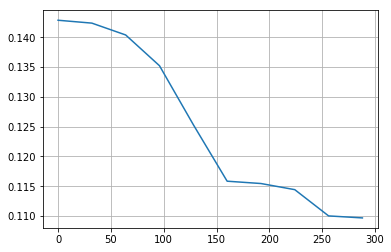

In [12]:
for conf in df.config.unique():
    print("Model configuration: \n{}".format(conf))
    for rep in df.repetition.unique():
        condition = (df.name=='test')&(df.config==conf)&(df.repetition==rep)
        values = df[condition]['metrics'].apply(lambda x: x.evaluate('iou')).values
        iters = np.arange(len(values)) * iters_to_test
        plt.plot(iters, values)
        plt.grid(True)
    plt.show()